In [138]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from numpy.linalg import inv

import scipy.optimize as optimize

from utils.plot_utils import newplot

In [149]:
# Define the log-likelihood
def likelihood(z, x1, x2, mu, Lambda, sigma1, sigma2):
    z1, z2 = z
    L = 0.5 * ((x1 - z1) / sigma1)**2 + 0.5 * ((x2 - z2) / sigma2)**2 + 0.5 * ((z1 * z2 - mu) / Lambda)**2
    return L


# Define the log-likelihood derivatives
def likelihood_derivatives(z, x1, x2, mu, Lambda, sigma1, sigma2):
    z1, z2 = z
    dLdz1 = -z2 * (z1 * z2 - mu) / Lambda**2 + (x1 - z1) / sigma1**2
    dLdz2 = -z1 * (z1 * z2 - mu) / Lambda**2 + (x2 - z2) / sigma2**2
    return [dLdz1, dLdz2]

# Define the Hessian matrix
def hessian(z1_star, z2_star, mu, Lambda, sigma1, sigma2):
    H11 = -1/sigma1**2 - z2_star**2/Lambda**2
    H12 = H21 = -z1_star * z2_star / Lambda**2 - (-mu + z1_star * z2_star) / Lambda**2
    H22 = -1/sigma2**2 - z1_star**2/Lambda**2
    return np.array([[H11, H12], [H21, H22]])

def z_star(x1, x2, mu, Lambda, sigma1, sigma2):
    initial_guess = [x1, x2]  # Initial guess for z1 and z2

    # Find the minimum of the likelihood
    z = optimize.minimize(likelihood, initial_guess, args=(x1, x2, mu, Lambda, sigma1, sigma2))
    z1_star, z2_star = z.x
    return z1_star, z2_star



    z1_star, z2_star = fsolve(likelihood_derivatives, initial_guess, args=(x1, x2, mu, Lambda, sigma1, sigma2))
    z1_star = np.abs(z1_star)
    z2_star = np.abs(z2_star)
    return z1_star, z2_star

# Define the resolutions
def resolutions(x1, x2, mu, Lambda, sigma1, sigma2):
    initial_guess = [x1, x2]  # Initial guess for z1 and z2
    z1_star, z2_star = z_star(x1, x2, mu, Lambda, sigma1, sigma2)
    H = hessian(z1_star, z2_star, mu, Lambda, sigma1, sigma2)
    covariance_matrix = inv(-H)
    resolution_z1 = np.sqrt(covariance_matrix[0, 0])
    resolution_z2 = np.sqrt(covariance_matrix[1, 1])
    return resolution_z1, resolution_z2


[[0.99874612 0.99842021 0.99800918 ... 0.62259131 0.62244421 0.6223274 ]
 [0.99858831 0.99822152 0.99775904 ... 0.62773647 0.62759901 0.62749023]
 [0.9984214  0.99801147 0.99749473 ... 0.6328652  0.63273664 0.6326347 ]
 ...
 [0.98361003 0.98002476 0.97582254 ... 0.90708829 0.90709851 0.9071088 ]
 [0.98318036 0.97952574 0.97525363 ... 0.91536433 0.91537974 0.91538796]
 [0.98274928 0.97902651 0.97468648 ... 0.92380454 0.92381943 0.92383142]]


/tmp/ipykernel_5181/3302654719.py:71: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(X, Y, improvement_z1.T, levels=[0.95], colors='black', linestyles='dashed', lw = 3, zorder = 5)
/tmp/ipykernel_5181/3302654719.py:72: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(X, Y, improvement_z1.T, levels=[1/np.sqrt(2)], colors='black', linestyles='dashed', lw = 3, zorder = 5)
/tmp/ipykernel_5181/3302654719.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('resolution_improvement_dijet.pdf', bbox_inches='tight')
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


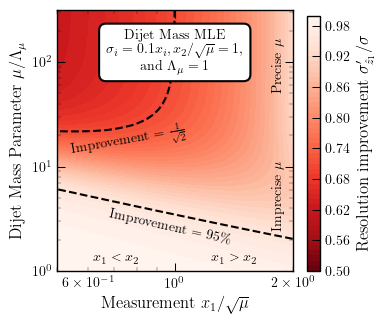

In [178]:
from matplotlib import colors

divnorm=colors.TwoSlopeNorm(vmin=0.85, vcenter=1., vmax=1.2)
# pcolormesh(your_data, cmap="coolwarm", norm=divnorm)



# Parameters
sigma2 = 0.1  # Example value
x2 = 1  # Fixed x2 for simplicity
mu_Lambda_ratios = np.logspace(0, 2.5, 51)  # Range of mu/Lambda
x1_values = np.linspace(0.5, 2, 50)  # Range of x1\mu

# Initialize arrays to hold resolutionsj
improvement_z1 = np.zeros((len(x1_values), len(mu_Lambda_ratios), ))
improvement_z2 = np.zeros((len(x1_values), len(mu_Lambda_ratios), ))

# Calculate improvements for each combination of mu/Lambda and x1
for i, x1_ratio in enumerate(x1_values):
        for j, mu_Lambda_ratio in enumerate(mu_Lambda_ratios):
                mu = mu_Lambda_ratio  # Assuming Lambda = 1 for simplicity
                x1 = x1_ratio * np.sqrt(mu)
                x2 = np.sqrt(mu)  
                Lambda = 1
                resolution_z1, resolution_z2 = resolutions(x1 , x2, mu, Lambda, 0.1 * x1 , 0.1 * x2)
                improvement_z1[i, j] = resolution_z1 / ( 0.1 * x1 ) 
                improvement_z2[i, j] = resolution_z2 / ( 0.1 * x2)

                # z1_star, z2_star = z_star(x1 * np.sqrt(mu), x2, mu, Lambda, 0.1 * x1 * np.sqrt(mu), sigma2)
                # improvement_z1[i, j] = z1_star / (x1 * np.sqrt(mu))
                # improvement_z2[i, j] = z2_star / x2

# # Clip to [0, 2] for better visualization
# improvement_z1 = np.clip(improvement_z1, 0, 1.5)

# Plotting
fig, ax = newplot("column")
X, Y = np.meshgrid(x1_values, mu_Lambda_ratios)

plt.xscale('log')
plt.yscale('log')


contour = plt.contourf(X, Y, improvement_z1.T, levels = np.linspace(0.5, 1, 51), cmap='Reds_r')
plt.xlabel('Measurement $x_1 / \sqrt{\mu}$')
plt.ylabel('Dijet Mass Parameter $\mu/\Lambda_\mu$')

print(improvement_z1)




# # Add labels to the plot
# plt.text(1.55, 0.25, 'Resolution Worsens', rotation = 45, fontsize=10, color='red', ha='center',)
# plt.text(1.375, 0.425, 'Resolution Improves', rotation = 45, fontsize=10, color='blue', ha='center',)


# Text in the upper left
plt.text(0.5, 0.925, f'Dijet Mass MLE\n$\sigma_i = 0.1x_i, x_2/\sqrt\mu = 1,$\nand $\Lambda_\mu = 1$', transform=plt.gca().transAxes, fontsize = 10,
        ha = 'center',multialignment='center', verticalalignment='top', backgroundcolor='white',bbox=dict(facecolor='w', linewidth=1.5,edgecolor='black', boxstyle='round,pad=0.5'), zorder = 10)


# Label for the colorbar
cb_ax = fig.add_axes([.925,.18,.04,.75])
cbar = plt.colorbar(cax=cb_ax)
cbar.set_label("Resolution improvement $\sigma_{\hat{z}_1}' / \sigma$")


# Highlight the contour where the improvement is X
# ax.contour(X, Y, improvement_z1.T, levels=[1], colors='black', linestyles='-', lw = 3, zorder = 10)
ax.contour(X, Y, improvement_z1.T, levels=[0.95], colors='black', linestyles='dashed', lw = 3, zorder = 5)
ax.contour(X, Y, improvement_z1.T, levels=[1/np.sqrt(2)], colors='black', linestyles='dashed', lw = 3, zorder = 5)

# Add text above the contour 
plt.gcf().text(0.525, 0.25, 'Improvement = 95\%', rotation = -12.5, fontsize=10, color='black', ha='center', va = "bottom")
plt.gcf().text(0.4, 0.5, r'Improvement = $\frac{1}{\sqrt{2}}$', rotation = 10, fontsize=10, color='black', ha='center', va = "bottom")

plt.text(0.75, 0.025, '$x_1 > x_2$', rotation = 0, fontsize=10, color='black', ha='center', va = "bottom", transform=ax.transAxes)
plt.text(0.25, 0.025, '$x_1 < x_2$', rotation = 0, fontsize=10, color='black', ha='center', va = "bottom", transform=ax.transAxes)

plt.text(0.935, 0.785, r'Precise $\mu$', rotation = 90, fontsize=10, color='black', ha='center', va = "center", transform=ax.transAxes)
plt.text(0.935, 0.285, r'Imprecise $\mu$', rotation = 90, fontsize=10, color='black', ha='center', va = "center", transform=ax.transAxes)



plt.savefig('resolution_improvement_dijet.pdf', bbox_inches='tight')

plt.show()